# CNN

In [12]:
import pandas as pd
import numpy as np
import math
import sklearn
from tensorflow import keras
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
import tensorflow as tf
tf.random.set_seed(8)

#### Define functions

In [14]:
# Imports data (daily or non-daily)
def import_function(daily):
    if daily == True:
        data = pd.read_excel('master_thesis_data_daily.xlsx', index_col=[0])
        y    = data.NO_folio_rate
        data.drop(['NO_folio_publication_date', 'NO_folio_rate'], axis=1, inplace=True)
    else:
        data = pd.read_excel('master_thesis_data.xlsx', index_col=[0])
        y    = data.NO_folio_publication_date
        data.drop('NO_folio_publication_date', axis=1, inplace=True)
    
    return data, y

# Shifts y to make predictions x periods ahead
def periods(data, y, periods):
    y_name = y.name
    y_temp = y.pct_change(periods).replace(np.nan, 0)
    temp   = pd.concat([y_temp.shift(-periods + 1).dropna(), data], join='inner', axis=1)
    y      = temp[y_name]
    temp.drop(y_name, axis=1, inplace=True)
    
    return temp, y

# Splits data into train and test 
def TT_split(x, y, daily, test_pct):
    if test_pct == 'fixed':
        if daily == True: split = 4507
        else: split = 128
    else:   
        split = int(len(x)*(1-test_pct))

    x_train, x_test = x[:split], x[split:]
    y_train, y_test = y[:split], y[split:]

    return x_train, x_test, y_train, y_test

# Normalizes x-variables based on x_train scales
def mm_normalize(x_train, x_test):
    scaler  = MinMaxScaler(feature_range=(0, 1)).fit(x_train)
    x_train = scaler.transform(x_train)
    x_test  = scaler.transform(x_test)
    
    return x_train, x_test

# Creates windows for CNN
def CNN_splitter(x_train, y_train, timesteps):
    x, y = list(), list()
    for i in range(len(x_train)):
        
        end_ix = i + timesteps
        
        if end_ix > len(x_train)-1:
            break
        
        seq_x = x_train[i:end_ix]
        seq_y = y_train[end_ix]
        x.append(seq_x)
        y.append(seq_y)
        
    return np.array(x), np.array(y)

In [15]:
# Defining CNN model
def CNN_model(x_train, x_test, y_train, y_test):
    CNN_mod = keras.models.Sequential()
    CNN_mod.add(keras.layers.Conv1D    (filters=50,   kernel_size=4, activation='tanh', input_shape=(x_train.shape[1], x_train.shape[2])))
    CNN_mod.add(keras.layers.MaxPool1D (pool_size=10, padding='same'))
    CNN_mod.add(keras.layers.Flatten())
    CNN_mod.add(keras.layers.Dropout   (rate=0.85))
    CNN_mod.add(keras.layers.Dense     (200,          activation='relu'))
    CNN_mod.add(keras.layers.Dense     (1,            activation='linear'))
    CNN_mod.compile                    (optimizer='adam', loss='mse')
    
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0005, patience = 10, restore_best_weights=True)
    history        = CNN_mod.fit(x_train, y_train, batch_size=256, epochs=200, callbacks=[early_stopping], validation_split=0.2, verbose=0)
    
    y_pred     = CNN_mod.predict(x_test, verbose=0)
    train_pred = CNN_mod.predict(x_train)
    test_MSE   = CNN_mod.evaluate(x_test, y_test, verbose=0)
    print("Test MSE: %.8f" % test_MSE)
    
    return y_pred, train_pred, history, test_MSE

#### Import data

In [16]:
daily       = False
data, folio = import_function(daily=daily)

# Add 1 lag of folio rate and remove NaN
data['folio_lag'] = folio.pct_change().shift(1).replace(np.nan, 0)[2:]
data.dropna(inplace=True)
folio = folio[1:]
split = int(len(folio[1:]) * 0.8)

#### Run model

In [17]:
y_pred, train_pred, history, test_MSE, ys, ys_train = {}, {}, {}, {}, {}, {}
np.random.seed(8)
wind = 5

for period in range(1, 6):
    
    x, y = periods(data, folio, periods=period)                                         # Shifting y-variable to predict x-number of periods ahead
    x, y = CNN_splitter(x, y, wind)                                                     # Creates "windows" of samples for CNN 
    x_train, x_test = x[:split-wind], x[split-wind:]
    y_train, y_test = y[:split-wind], y[split-wind:]                                    # Splits dataset into train og test
    
    y_hat, train_hat, historie, MSE = CNN_model(x_train, x_test, y_train, y_test)       # Run the CNN-model
    
    y_pred    ["y_pred_{0}"    .format(period)] = y_hat
    train_pred["train_pred_{0}".format(period)] = train_hat
    history   ["history_{0}"   .format(period)] = historie
    test_MSE  ["test_MSE_{0}"  .format(period)] = MSE
    ys        ["ys_test_{0}"   .format(period)] = y_test
    ys_train  ["ys_train_{0}"  .format(period)] = y_train

Test MSE: 0.09454845
Test MSE: 0.14010949
Test MSE: 0.16191773
Test MSE: 0.24767356
Test MSE: 0.33472911


#### Manage results

In [18]:
for key in y_pred.keys():
    y_pred[str(key)] = y_pred[str(key)].reshape(-1).tolist()

comb_y_test = pd.DataFrame.from_dict(ys,     orient='index').transpose()
comb_y_pred = pd.DataFrame.from_dict(y_pred, orient='index').transpose()
comb_y_test.index, comb_y_pred.index = folio.index[split+1:], folio.index[split+1:]
comb_y_pred.columns = ['y_oos_pred_0', 'y_oos_pred_1', 'y_oos_pred_2', 'y_oos_pred_3', 'y_oos_pred_4']
comb_y_test.columns = ['y_test_0', 'y_test_1', 'y_test_2', 'y_test_3', 'y_test_4']

for i in range(5):
    comb_y_test.iloc[:, i] = folio[split-1:].shift(1).dropna() * (comb_y_test.iloc[:, i] + 1)
    comb_y_pred.iloc[:, i] = folio[split-1:].shift(1).dropna() * (comb_y_pred.iloc[:, i] + 1)

NB = pd.read_excel('Styringsrenter_sammensatt.xlsx', index_col=[1])
NB.drop('Quarter', axis=1, inplace=True)
NB.drop(NB.iloc[:, 5:], axis=1, inplace=True)
NB.dropna(inplace=True)
NB = NB / 100

comparison = pd.concat([comb_y_test, comb_y_pred, NB], axis=1, join='inner')

for key in test_MSE.keys():
    test_MSE[str(key)] = np.sqrt(test_MSE[str(key)])

#### Plot results

Text(0, 0.5, 'Loss')

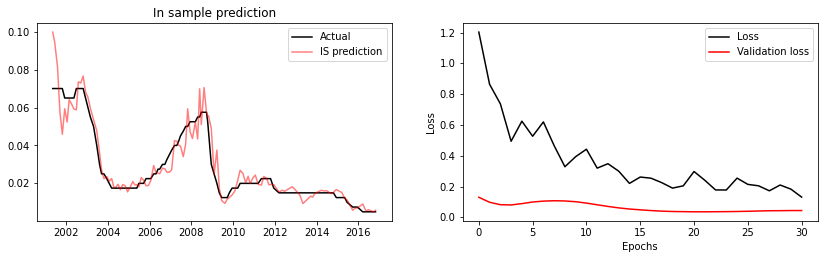

In [19]:
train_y_0    = pd.DataFrame(ys_train['ys_train_1'].tolist(), columns=["train_y_0"], index=folio.index[wind+1:split+1])
train_pred_0 = pd.DataFrame(train_pred['train_pred_1'].reshape(-1).tolist(), columns=["train_pred_0"], index=folio.index[wind+1:split+1])

fig = plt.figure(figsize = (14, 8))

plt.subplot2grid((2, 2), (0, 0), colspan = 1, rowspan = 1)
plt.plot(folio.index[wind+1:split+1], (train_y_0['train_y_0'] + 1) * folio[wind:split+1].shift(1).dropna(), color = "black", label = "Actual")
plt.plot(folio.index[wind+1:split+1], (train_pred_0['train_pred_0'] + 1) * folio[wind:split+1].shift(1).dropna(), color = "Red",   alpha = 0.5, label = "IS prediction")
plt.legend()
plt.title("In sample prediction")

plt.subplot2grid((2, 2), (0, 1), colspan = 1, rowspan = 1)
plt.plot(history['history_1'].history['loss'], color = "black", label = "Loss")
plt.plot(history['history_1'].history['val_loss'], color = "red", label = "Validation loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")

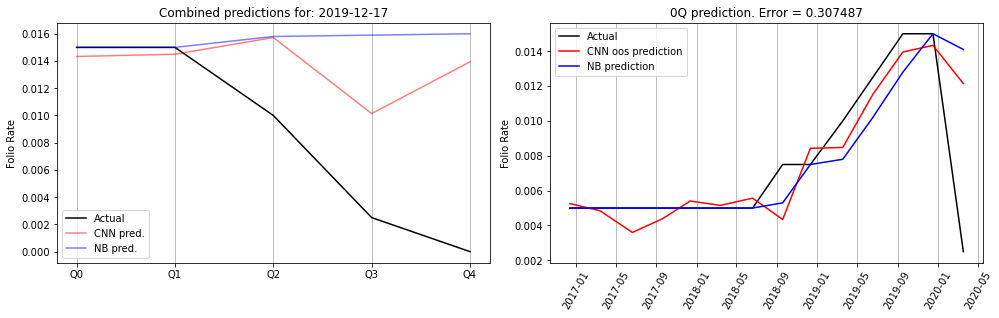

In [20]:
time = ['Q0', 'Q1', 'Q2', 'Q3', 'Q4']
serie = 12

fig = plt.figure(figsize = (14, 8))

plt.subplot2grid((2, 2), (0, 0), colspan = 1, rowspan = 1)
plt.plot(time, comparison.iloc[serie, :5].values,   color = "black", label = "Actual")
plt.plot(time, comparison.iloc[serie, 5:10].values, color = "red",   alpha = 0.5, label = "CNN pred.")
plt.plot(time, comparison.iloc[serie, 10:].values,  color = "blue",  alpha = 0.5, label = "NB pred.")
plt.title("Combined predictions for: " + str(comparison.index[serie].date()))
plt.ylabel("Folio Rate")
plt.legend()
plt.grid(axis = 'x')

plt.subplot2grid((2, 2), (0, 1), colspan = 1, rowspan = 1)
plt.plot(comparison.iloc[:, 0],  color= "black", label = "Actual")
plt.plot(comparison.iloc[:, 5],  color= "red",   label = "CNN oos prediction")
plt.plot(comparison.iloc[:, 10], color= "blue",  label = "NB prediction")
plt.title("0Q prediction. Error = " + str(round(test_MSE['test_MSE_1'], 6)))
plt.ylabel("Folio Rate")
plt.xticks(rotation=60)
plt.legend()
plt.grid(axis = 'x')

plt.tight_layout()

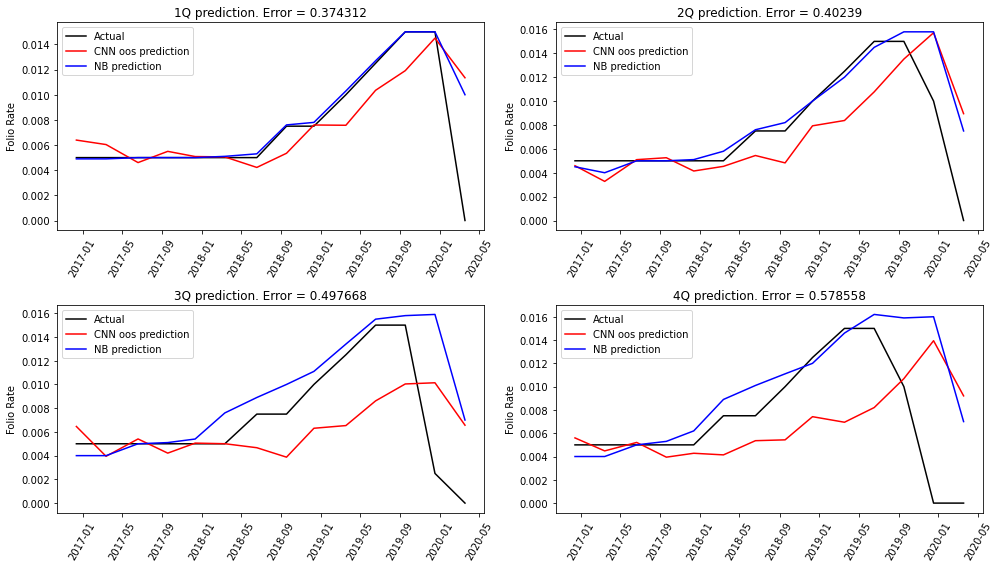

In [21]:
fig = plt.figure(figsize = (14, 8))

plt.subplot2grid((2, 2), (0, 0), colspan = 1, rowspan = 1)
plt.plot(comparison.iloc[:, 1],  color= "black", label = "Actual")
plt.plot(comparison.iloc[:, 6],  color= "red",   label = "CNN oos prediction")
plt.plot(comparison.iloc[:, 11], color= "blue",  label = "NB prediction")
plt.title("1Q prediction. Error = " + str(round(test_MSE['test_MSE_2'], 6)))
plt.ylabel("Folio Rate")
plt.xticks(rotation=60)
plt.legend()

plt.subplot2grid((2, 2), (0, 1), colspan = 1, rowspan = 1)
plt.plot(comparison.iloc[:, 2],  color= "black", label = "Actual")
plt.plot(comparison.iloc[:, 7],  color= "red",   label = "CNN oos prediction")
plt.plot(comparison.iloc[:, 12], color= "blue",  label = "NB prediction")
plt.title("2Q prediction. Error = " + str(round(test_MSE['test_MSE_3'], 6)))
plt.ylabel("Folio Rate")
plt.xticks(rotation=60)
plt.legend()

plt.subplot2grid((2, 2), (1, 0), colspan = 1, rowspan = 1)
plt.plot(comparison.iloc[:, 3],  color= "black", label = "Actual")
plt.plot(comparison.iloc[:, 8],  color= "red",   label = "CNN oos prediction")
plt.plot(comparison.iloc[:, 13], color= "blue",  label = "NB prediction")
plt.title("3Q prediction. Error = " + str(round(test_MSE['test_MSE_4'], 6)))
plt.ylabel("Folio Rate")
plt.xticks(rotation=60)
plt.legend();

plt.subplot2grid((2, 2), (1, 1), colspan = 1, rowspan = 1)
plt.plot(comparison.iloc[:, 4], color= "black", label = "Actual")
plt.plot(comparison.iloc[:, 9], color= "red", label = "CNN oos prediction")
plt.plot(comparison.iloc[:, 14], color= "blue", label = "NB prediction")
plt.title("4Q prediction. Error = " + str(round(test_MSE['test_MSE_5'], 6)))
plt.ylabel("Folio Rate")
plt.xticks(rotation=60)
plt.legend();

plt.tight_layout()

In [22]:
comb_y_pred.to_excel('CNN_predictions_stationary.xlsx')